# Setup
## Import libraries

In [1]:
import numpy as np 
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import copy
np.random.seed(0)
%load_ext line_profiler

## Define constants

In [2]:
L = 2*np.pi # periodic domain size 
dt = 0.01   # time step size 

# define boundaries of simulation box
x0 = 0      
x1 = L
z0 = 0
z1 = L 

# define training parameters
Ne =  5000  # number of episodes
gamma = 0.999    # discount - how much we weight future to present rewards. Close to 0 = myopic view. 
eps = 0.0           # fraction of the time we allow for exploration in selecting the following action.
                  # value of 0 means we always take the greedy choice; no exploration.
    
alpha = 14e-2   # learning rate 
Ns = 4000      # number of steps in an episode 
N_ensemble = 1 # sample size for ensemble average. I.e. how many times we repeat a given episode.

# define reinforcement learning problem 
N_states = 12 # number of states - one for each coarse-grained degree of vorticity 
N_actions = 4 # number of actions - one for each coarse-grained swimming direction

# define dimensionless groups
Φ = 0.3 # swimming number = v_s/u_0
Ψ = 1.0 # stability number = B w_0. B is the characteristic time a perturbed cell takes to return 
         # to orientation ka if w = 0. smaller means swimming more aligned with ka. 
    
# plotting parameters
n_updates = 1000 # how often to plot the trajectory undertaken by the particle during the learning process. measured
                 # in number of episodes. 
    
# translational and rotational diffusivity 
D0 = 0.0
Dr = 0.00

# Based on SI of their paper
if Φ == 10 and Ψ == 0.1:
    Ns = 4000
    alpha = 10e-2
elif Ψ == 0.1 and Φ == 0.3:
    alpha = 18e-2
    Ns = 2000
elif Ψ == 1.0 and Φ == 0.3:
    alpha = 14e-2
    Ns = 4000 

## Utility functions

In [3]:
# documentation: https://github.com/scipy/scipy/blob/v0.14.0/scipy/stats/stats.py#L1864
# license: https://www.scipy.org/scipylib/license.html
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Runga-Kutta 4(5) integration for one step 
    # see https://stackoverflow.com/questions/54494770/how-to-set-fixed-step-size-with-scipy-integrate
def DoPri45Step(f,t,x,h):

    k1 = f(t,x)
    k2 = f(t + 1./5*h, x + h*(1./5*k1) )
    k3 = f(t + 3./10*h, x + h*(3./40*k1 + 9./40*k2) )
    k4 = f(t + 4./5*h, x + h*(44./45*k1 - 56./15*k2 + 32./9*k3) )
    k5 = f(t + 8./9*h, x + h*(19372./6561*k1 - 25360./2187*k2 + 64448./6561*k3 - 212./729*k4) )
    k6 = f(t + h, x + h*(9017./3168*k1 - 355./33*k2 + 46732./5247*k3 + 49./176*k4 - 5103./18656*k5) )

    v5 = 35./384*k1 + 500./1113*k3 + 125./192*k4 - 2187./6784*k5 + 11./84*k6
    k7 = f(t + h, x + h*v5)
    v4 = 5179./57600*k1 + 7571./16695*k3 + 393./640*k4 - 92097./339200*k5 + 187./2100*k6 + 1./40*k7;

    return v4,v5

# def DoPri45integrate(f, t, x0):
#     N = len(t)
#     x = [x0]
#     for k in range(N-1):
#         v4, v5 = DoPri45Step(f,t[k],x[k],t[k+1]-t[k])
#         x.append(x[k] + (t[k+1]-t[k])*v5)
#     return np.array(x)

# def mms_ode(t,y): return np.array([ y[1], np.sin(np.sin(t))-np.sin(t)-np.sin(y[0]) ])
# mms_x0 = [0.0, 1.0]

# for h in [0.2, 0.1, 0.01][::-1]:
#     t = np.arange(0,20,h);
#     y = DoPri45integrate(mms_ode,t,mms_x0)
#     plt.plot(t, (y[:,0]-np.sin(t))/h**5, 'o', ms=3, label = "h=%.4f"%h);
# plt.grid(); plt.legend(); plt.show()  

## Define useful data structures
### Define a dictionary of the possible states and their assigned indices

In [4]:
direction_states = ["right","down","left","up"] # coarse-grained directions
vort_states = ["w+", "w0", "w-"] # coarse-grained levels of vorticity 
product_states = [(x,y) for x in direction_states for y in vort_states]  # all possible states
state_lookup_table = {product_states[i]:i for i in range(len(product_states))} # returns index of given state
print(product_states)

[('right', 'w+'), ('right', 'w0'), ('right', 'w-'), ('down', 'w+'), ('down', 'w0'), ('down', 'w-'), ('left', 'w+'), ('left', 'w0'), ('left', 'w-'), ('up', 'w+'), ('up', 'w0'), ('up', 'w-')]


### Define an agent class for reinforcement learning

In [5]:
class Agent:
    def __init__(self):
        self.r = np.zeros(Ns) # reward for each stage
        self.t = 0            # time
        
    # calculate reward given from entering a new state after a selected action is undertaken
    def calc_reward(self):
        # enforce implementation by subclass
        if self.__class__ == AbstractClass:
                raise NotImplementedError
                
    def update_state(self):
        # enforce implementation by subclass
        if self.__class__ == AbstractClass:
                raise NotImplementedError
                
    def take_random_action(self):
        # enforce implementation by subclass
        if self.__class__ == AbstractClass:
                raise NotImplementedError
                
    def take_greedy_action(self, Q):
        # enforce implementation by subclass
        if self.__class__ == AbstractClass:
                raise NotImplementedError

### Define swimmer class derived from agent

In [6]:
class Swimmer(Agent):
    def __init__(self):
        # call init for superclass
        super().__init__()
        
        # local position within the periodic box. X = [x, z]^T with 0 <= x < 2 pi and 0 <= z < 2 pi
        self.X = np.array([np.random.uniform(0, L), np.random.uniform(0, L)])
        
        # absolute position. -inf. <= x_total < inf. and -inf. <= z_total < inf.
        self.X_total = self.X
        
        # particle orientation 
        self.theta = np.random.uniform(0, 2*np.pi) # polar angle theta in the x-z plane 
        self.p = np.array([np.cos(self.theta), np.sin(self.theta)]) # p = [px, pz]^T
        
        # translational and rotational velocity
        self.U = np.zeros(2)
        self.W = np.zeros(2)
        
        # preferred swimming direction (equal to [1,0], [0,1], [-1,0], or [0,-1])
        self.ka = np.array([0,1])
        
        # history of local and global position. Only store information for this episode. 
        self.history_X = [self.X]
        self.history_X_total = [self.X_total]
        
        # local vorticity at the current location
        _, _, self.w = tgf(self.X[0], self.X[1])
        
        # update coarse-grained state
        self.update_state()
        
    def reinitialize(self):
        self.X = np.array([np.random.uniform(0, L), np.random.uniform(0, L)])
        self.X_total = self.X
        
        self.theta = np.random.uniform(0, 2*np.pi) # polar angle theta in the x-z plane 
        self.p = np.array([np.cos(self.theta), np.sin(self.theta)]) # p = [px, pz]^T
        
        self.U = np.zeros(2)
        self.W = np.zeros(2)

        self.ka = np.array([0,1])

        self.history_X = [self.X]
        self.history_X_total = [self.X_total]
        
        self.t = 0 
        
    def update_kinematics(self, int_method = "euler"):
        if int_method == "rk45":
            y0 = np.concatenate((self.X,self.p))
            _, v5 = DoPri45Step(self.calc_velocity_rk45,self.t,y0,dt)
            y = y0 + dt*v5
            self.X = y[:2]
            self.p = y[2:]
            dx = self.X - self.history_X[-1]
            self.X_total = self.X_total + dx 
            
            # check if still in the periodic box
            self.check_in_box()
            
            # ensure the vector p has unit length 
            self.p /= (self.p[0]**2 + self.p[1]**2)**(1/2)

            # update polar angle
            x = self.p[0]
            yy = self.p[1]
            self.theta = np.arctan2(yy,x) if yy >= 0 else (np.arctan2(yy,x) + 2*np.pi)

            # store positions
            self.history_X.append(self.X)
            self.history_X_total.append(self.X_total)
            
        elif int_method == "euler":
            # calculate new translational and rotational velocity 
            self.calc_velocity()

            self.update_position(int_method)
            self.update_orientation(int_method)
        else:
            raise Exception("Integration method must be 'Euler' or 'rk45'")

        self.t = self.t + dt
    
    def calc_velocity_rk45(self, t, y):
        x = y[0]
        z = y[1]
        px = y[2]
        pz = y[3]
        ux, uz, self.w = tgf(x, z)
        
        U0 = ux + Φ*px
        U1 = uz + Φ*pz
        
        ka_dot_p = self.ka[0]*px + self.ka[1]*pz
        W0 = 1/2/Ψ*(self.ka[0] - ka_dot_p*px) + 1/2*pz*self.w
        W1 = 1/2/Ψ*(self.ka[1] - ka_dot_p*pz) + 1/2*-px*self.w
        
        return np.array([U0, U1, W0, W1])
        
    
    def update_position(self, int_method):
        # use explicit euler to update 
        dx = dt*self.U
        if D0 > 0: dx = dx + np.sqrt(2*D0*dt)*np.random.normal(size=2)
        self.X = self.X + dx
        self.X_total = self.X_total + dx
        
        # check if still in the periodic box
        self.check_in_box()
        
        # store positions
        self.history_X.append(self.X)
        self.history_X_total.append(self.X_total)
        
        # TODO: add in noise in update
    
    def update_orientation(self, int_method):
        self.p = self.p + dt*self.W 
        
        # ensure the vector p has unit length 
        self.p /= (self.p[0]**2 + self.p[1]**2)**(1/2)         
        
        # if rotational diffusion is present
        if Dr > 0:
            self.p = self.p + (np.eye(2) - np.outer(self.p,self.p))@np.sqrt(2*Dr*dt)*np.random.normal(size=2)
            self.p /= (self.p[0]**2 + self.p[1]**2)**(1/2)

        # update polar angle
        x = self.p[0]
        y = self.p[1]
        self.theta = np.arctan2(y,x) if y >= 0 else (np.arctan2(y,x) + 2*np.pi)
        

    def calc_velocity(self):
        ux, uz, self.w = tgf(self.X[0], self.X[1])
        
        # careful - computing in the following way is significantly slower: self.U = np.array(ux, uz) + Φ*self.p
        self.U[0] = ux + Φ*self.p[0]
        self.U[1] = uz + Φ*self.p[1]
        
        px = self.p[0]
        pz = self.p[1]
        ka_dot_p = self.ka[0]*px + self.ka[1]*pz
        self.W[0] = 1/2/Ψ*(self.ka[0] - ka_dot_p*px) + 1/2*pz*self.w 
        self.W[1] = 1/2/Ψ*(self.ka[1] - ka_dot_p*pz) + 1/2*-px*self.w 
        
        
    def check_in_box(self): 
        if self.X[0] < x0:
            self.X[0] += L 
        elif self.X[0] > x1:
            self.X[0] -= L 
        if self.X[1] < z0:
            self.X[1] += L 
        elif self.X[1] > z1:
            self.X[1] -= L    
            
    def calc_reward(self, n):
        self.r[n] = self.history_X_total[-1][1]-self.history_X_total[-2][1]
        
    def update_state(self):
        if self.w < -0.33:
            w_state = "w-"
        elif self.w >= -0.33 and self.w <= 0.33:
            w_state = "w0"
        elif self.w > 0.33:
            w_state = "w+"
        else:
            raise Exception("Invalid value of w detected: ", w)

        if self.theta >= np.pi/4 and self.theta < 3*np.pi/4:
            p_state = "up"
        elif self.theta >= 3*np.pi/4 and self.theta < 5*np.pi/4:
            p_state = "left"
        elif self.theta >= 5*np.pi/4 and self.theta < 7*np.pi/4:
            p_state = "down"
        elif (self.theta >= 7*np.pi/4 and self.theta <= 2*np.pi) or (self.theta >= 0 and self.theta < np.pi/4):
            p_state = "right"
        else:
            raise Exception("Invalid value of theta detected: ", theta)

        self.my_state = (p_state, w_state)
        
    def take_greedy_action(self, Q):
        state_index = state_lookup_table[self.my_state]
        action_index = np.argmax(Q[state_index])  # find largest entry in this row of Q (i.e. this state)
        if action_index == 0:   # up
            self.ka = [0, 1]
        elif action_index == 1: # down
            self.ka = [0, -1]
        elif action_index == 2: # right
            self.ka = [1, 0]
        else:                   # left
            self.ka = [-1, 0]
        return action_index
            
    def take_random_action(self):
        action_index = np.random.randint(4)
        if action_index == 0:   # up
            self.ka = [0, 1]
        elif action_index == 1: # down
            self.ka = [0, -1]
        elif action_index == 2: # right
            self.ka = [1, 0]
        else:                   # left
            self.ka = [-1, 0]
        return action_index

## Define Taylor-Green vortex

In [7]:
# given position, return local velocity and vorticity 
def tgf(x, z):
    ux = -1/2*np.cos(x)*np.sin(z)
    uz = 1/2*np.sin(x)*np.cos(z)
    w = -np.cos(x)*np.cos(z)
    return ux, uz, w

In [8]:
# visualize 
x = np.linspace(0,L,100)
z = np.linspace(0,L,100)
xv, zv = np.meshgrid(x, z)
ux, uz, w = tgf(xv, zv)

fig = go.Figure(data = go.Contour(x = x, y = z, z=w))

fig.update_layout(
    title=r"$\text{Vorticity }(w)$",
    xaxis_title="$x$",
    yaxis_title="$z$"
)

fig.show()

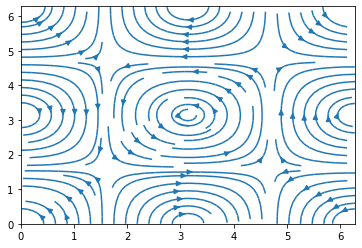

In [9]:
plt.streamplot(x,z,ux,uz)

Does the above make sense? consider $x=0$, $y=0$. There, the vorticity is large and negative. This makes sense in light of the streamplot (considering the right-hand rule and noting that positive $y$ would point into the page since the coordinate-system is right-handed). 

# Training process

In [10]:
smart_stored_histories = []       # store position = f(t) every so often for an episode (smart particles)
naive_stored_histories = []       # store position = f(t) every so often for an episode (naive particles)

def training(smart_stored_histories, naive_stored_histories):
    Σ = np.zeros(Ne)            # learning gain per episode
    hist_R_tot_smart = np.zeros(Ne)
    hist_R_tot_naive= np.zeros(Ne)
    
    state_action_counter = np.zeros((N_states,N_actions))
    
    naive = Swimmer()
    smart = Swimmer()
    

    Q = L*Ns*np.ones((12, 4))   # 12 states, 4 possible actions. Each column is an action, ka: up, down, right, left
#     Q = np.zeros((12,4))
    prev_Q = Q

    for ep in tqdm(range(Ne)):  # for each episode

        # total long-term vertical displacement, one for each realization
        R_tots_naive = np.zeros(N_ensemble)
        R_tots_smart = np.zeros(N_ensemble)

        # initialize Q with its final value from the last episode
        Q = prev_Q

        # iterate over different realizations of noise and initial conditions
        for realization in range(N_ensemble):

            # assign random orientation and position 
            smart.reinitialize()
            naive.reinitialize()
            naive = copy.deepcopy(smart)
            
            # iterate over stages within an episode
            for stage in range(Ns): 
                
                # select an action eps-greedily. Note naive never changes its action/strategy (i.e. trying to swim up)
                if np.random.uniform(0, 1) < eps:
                    action_index = smart.take_random_action()
                else:
                    action_index = smart.take_greedy_action(Q)

                # record prior state
                old_state_index = state_lookup_table[smart.my_state]

                # given selected action, update the state
                naive.update_kinematics()
                smart.update_kinematics()
                smart.update_state()      # only need to update smart particle since naive has ka = [0, 1]


                # calculate reward based on new state
                naive.calc_reward(stage)
                smart.calc_reward(stage)

                # update Q matrix 
                state_index = state_lookup_table[smart.my_state]
                state_action_counter[state_index,action_index] += 1
                Q[old_state_index, action_index] = Q[old_state_index, action_index] + alpha*(smart.r[stage] + \
                        gamma*np.max(Q[state_index,:])-Q[old_state_index,action_index])
 
                
            # calculate Rtot for this realization
            R_tot_naive = np.sum(naive.r)
            R_tot_smart = np.sum(smart.r)

            # collect Rtot across realizations
            R_tots_naive[realization] = R_tot_naive
            R_tots_smart[realization] = R_tot_smart

        # TODO: add warning based on average initial position and orientation vanishing 
    #     if abs(signaltonoise(R_tots_naive))<1 or abs(signaltonoise(R_tots_smart))<1:
    #       raise Exception(("Signal to nosie ratios % 5.2f and % 5.2f are too small. " + \
    #             " Consider increasing ensemble size.") %(signaltonoise(R_tots_naive), signaltonoise(R_tots_smart)))

        # store final Q for this episode
        prev_Q = Q

        # calculate ensemble average of total gain for this episode
        avg_R_tot_naive = np.mean(R_tots_naive)
        avg_R_tot_smart = np.mean(R_tots_smart)
#         if avg_R_tot_naive < avg_R_tot_smart:
#             print("stopping at episode " + str(ep) + " because avg_R_tot_naive < avg_R_tot_smart")
#             print(avg_R_tot_naive, avg_R_tot_smart)
#             break

        # calculate learning gain for this episode
        Σ[ep] = avg_R_tot_smart/avg_R_tot_naive - 1
        hist_R_tot_smart[ep] = avg_R_tot_smart
        hist_R_tot_naive[ep] = avg_R_tot_naive

        # plot trajectory every so often 
        if ep%n_updates==0 or ep==Ne-1:
            smart_history_X_total = np.array(smart.history_X_total)
            smart_stored_histories.append((ep,smart_history_X_total))
            naive_history_X_total = np.array(naive.history_X_total)
            naive_stored_histories.append((ep,naive_history_X_total))
        
        # save optimal policy
        if ep==Ne-1:
            np.save("Q_alpha_" + str(alpha) + "_Ns_" + str(Ns) + "_Ne_" + str(Ne) + "_Φ_" + str(Φ).replace(".","d")\
                    + "_Ψ_" + str(0.1).replace(".","d"), Q)
    
    return Q, Σ, smart, naive, hist_R_tot_smart, hist_R_tot_naive, state_action_counter

Q, Σ, smart, naive, hist_R_tot_smart, hist_R_tot_naive, state_action_counter = \
    training(smart_stored_histories, naive_stored_histories)

# %lprun -f training  Q = training(stored_histories, Σ, smart, naive)
# %prun -s cumulative Q = training(stored_histories, Σ, smart, naive)
# for information on prun: https://docs.python.org/3/library/profile.html#module-pstats
# see also https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025 for profiling/timing

# may need to parallelize over realizations: https://joblib.readthedocs.io/en/latest/parallel.html

In [11]:
# %lprun -f Swimmer.update_kinematics naive.update_kinematics() # most time in calc_velocity then in update_orientation

In [12]:
# %lprun -f Swimmer.calc_velocity smart.calc_velocity() # most time in calc_velocity then in update_orientation

## Plot learning gain over time

In [23]:
fig = go.Figure()
N = 500
fig.add_trace(go.Scatter(x=np.arange(N,Ne+1), y=100*moving_average(Σ,N), mode='lines'))
fig.update_layout(
    title="Learning gain over time",
    xaxis_title="Episode, E",
    yaxis_title=r"$\text{Learning gain, }\Sigma$",
)
fig.show()

## Plot total reward as a function of episode

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(Ne), y=moving_average(hist_R_tot_smart,N), mode='lines', name = "Smart"))
fig.add_trace(go.Scatter(x=np.arange(Ne), y=moving_average(hist_R_tot_naive,N), mode='lines', name = "Naive"))
fig.update_layout(
    title="Total reward vs. episode #",
    xaxis_title="Episode #",
    yaxis_title="Total reward, Rtot",
)
fig.show()

## Visualize policy

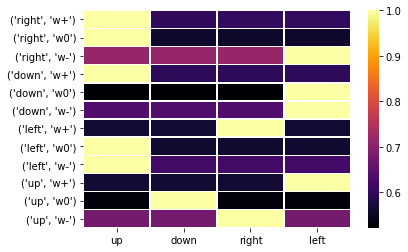

[[1.         0.60059339 0.60074609 0.60071518]
 [1.         0.55956824 0.55955465 0.55962157]
 [0.7161827  0.7162963  0.71620043 1.        ]
 [1.         0.5957339  0.59567756 0.59579884]
 [0.5222348  0.52227133 0.52224365 1.        ]
 [0.63433126 0.63432124 0.63433193 1.        ]
 [0.56616409 0.56621633 1.         0.56617719]
 [1.         0.56270927 0.56260898 0.56272123]
 [1.         0.62073887 0.6208721  0.6208689 ]
 [0.56628615 0.56616887 0.56611106 1.        ]
 [0.53188928 1.         0.53188778 0.53182204]
 [0.67799579 0.67802215 1.         0.6782469 ]]


In [15]:
Qnorm = Q
max_per_row = np.max(Q,1)
for row in range(Q.shape[0]):
    Qnorm[row,:] = Qnorm[row,:]/max_per_row[row]
ax = sns.heatmap(Qnorm, linewidth=0.5, xticklabels = ["up","down","right","left"], yticklabels = product_states, \
                cmap = 'inferno')
plt.show()
print(Qnorm)

## Plot trajectories for for selected episodes

In [16]:
for i in range(len(smart_stored_histories)):
        ep, smart_history_X_total = smart_stored_histories[i]
        ep, naive_history_X_total = naive_stored_histories[i]
        fig = go.Figure(go.Scatter(x=smart_history_X_total[:,0], y=smart_history_X_total[:,1],mode='markers',
            name = "smart",
            marker=dict(size=4,
                color=np.linspace(0,Ns,Ns+1), #set color equal to a variable
                colorscale='blues', # one of plotly colorscales
                showscale=True,
                colorbar=dict(title="Smart")
            )))
        fig.add_trace(go.Scatter(x=naive_history_X_total[:,0], y=naive_history_X_total[:,1],mode='markers',
            name = "naive",
            marker=dict(size=4,
                color=np.linspace(0,Ns,Ns+1), #set color equal to a variable
                colorscale='reds', # one of plotly colorscales
                showscale=True,
                colorbar=dict(title="Naive",x=1.15)
            )))
        fig.update_layout(
            title="Trajectory for episode " + str(ep),
            xaxis_title="$x$",
            yaxis_title="$z$",
            legend_orientation="h",
            showlegend = False
        )
        fig.show()
    

## Plot rewards for latest episode

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(Ns), y=naive.r, mode='lines', name = "Naive"))
fig.add_trace(go.Scatter(x=np.arange(Ns), y=smart.r, mode='lines', name = "Smart"))
fig.update_layout(
    title="Reward as a function of time. R_tot_naive = " + str(np.sum(naive.r)) + \
        " and R_tot_smart = " + str(np.sum(smart.r)),
    xaxis_title="Step #",
    yaxis_title="Reward, r",
)
fig.show()

## Visualize strategy learned by smart gyrotactic particle

In [18]:
fig = go.Figure(data = go.Contour(x = x, y = z, z=w, colorscale='Gray', colorbar=dict(x=1,title="w")))

history_X = np.array(smart.history_X)

fig.add_trace(go.Scatter(x=history_X[:,0], y=history_X[:,1],mode='markers',
    marker=dict(
        size=4,
        color=np.linspace(0,Ns,Ns+1), #set color equal to a variable
        colorscale='plasma', # one of plotly colorscales
        showscale=True,
        colorbar=dict(x=1.1,title="Step")
    )))

fig.update_layout(
    title="Trajectory for the final episode",
    xaxis_title="$x$",
    yaxis_title="$z$",
    xaxis=dict(
        range=[0, L]
    ),
    yaxis=dict(
        range=[0, L]
    )
)

fig.show()

In [19]:
# list of colorscales
# ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
#              'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
#              'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
#              'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
#              'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
#              'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
#              'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
#              'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
#              'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
#              'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
#              'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
#              'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
#              'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
#              'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']

# Testing

## Difference between using explicit euler and RK45 is minimal

In [20]:
import copy
test_eul = Swimmer()
test_rk45 = copy.deepcopy(test_eul)

for i in range(Ns):
    test_eul.update_kinematics("euler")
    test_rk45.update_kinematics("rk45")

history_eul = np.array(test_eul.history_X_total)
history_rk45 = np.array(test_rk45.history_X_total)

fig = go.Figure(go.Scatter(x=history_eul[:,0], y=history_eul[:,1],mode='markers',
    name = "smart",
    marker=dict(size=4,
        color=np.linspace(0,Ns,Ns+1), #set color equal to a variable
        colorscale='blues', # one of plotly colorscales
        showscale=True,
        colorbar=dict(title="Euler")
    )))
fig.add_trace(go.Scatter(x=history_rk45[:,0], y=history_rk45[:,1],mode='markers',
    name = "naive",
    marker=dict(size=4,
        color=np.linspace(0,Ns,Ns+1), #set color equal to a variable
        colorscale='reds', # one of plotly colorscales
        showscale=True,
        colorbar=dict(title="RK45",x=1.15)
    )))
fig.update_layout(
    title="Explicit euler vs. RK45",
    xaxis_title="$x$",
    yaxis_title="$z$",
    legend_orientation="h",
    showlegend = False
)
fig.show()
    

In [21]:
# import plotly.express as px
# fig = px.bar(x=np.arange(12),y=states_counter)
# fig.show()
print(state_action_counter)
print(np.min(state_action_counter))

[[  55156.   85129.   57083.   34141.]
 [  87681.  899506.  159821.   51270.]
 [  57597.   67607.  525697.   38704.]
 [  36859.   72482.   81568.   48500.]
 [  47196.   90839.   67622.   73697.]
 [  33211.   59219.   41223.   45707.]
 [  84533.  154609.   48736.  459211.]
 [ 111303. 1153722.   61133.  362938.]
 [  64592.   60268.   34800.   86613.]
 [ 214405.   61484.  429932.  133679.]
 [2217223.  171899.  237001.   99219.]
 [ 305477.   39710.  180159.  409839.]]
33211.0
